In [1]:
import torch
from torch import nn
# from model import LSTMModel,BiLSTM_FullOutput
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
train_data_path = "../../train_hourly.csv"
test_data_path = "../../test_hourly.csv"

In [3]:
train_df = pd.read_csv(train_data_path, index_col='DateTime', parse_dates=True)
test_df = pd.read_csv(test_data_path, index_col='DateTime', parse_dates=True)

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib # 用于保存scaler

# # 1. 初始化Scaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# 
# # 2. Fit on train data AND transform it
# train_scaled = scaler.fit_transform(train_df)
# 
# # 3. Transform test data using the SAME scaler
# test_scaled = scaler.transform(test_df)
train_scaled = train_df.values.astype(np.float32)  
test_scaled = test_df.values.astype(np.float32)

# 4. 保存scaler以备后用 (非常重要，我们需要它来反向转换预测结果)
# joblib.dump(scaler, 'scaler.gz') 

print("数据归一化完成。")
print(f"训练数据归一化后维度: {train_scaled.shape}")
print(f"测试数据归一化后维度: {test_scaled.shape}")

数据归一化完成。
训练数据归一化后维度: (17911, 12)
测试数据归一化后维度: (16678, 12)


In [5]:
def create_sliding_windows(data, input_seq_len, output_seq_len, target_col_index):
    X, y = [], []
    n_samples = len(data)
    # 确保我们有足够的数据来创建至少一个窗口
    if n_samples < input_seq_len + output_seq_len:
        return np.array(X), np.array(y)
        
    for i in range(n_samples - input_seq_len - output_seq_len + 1):
        # 输入序列 (所有特征)
        input_window = data[i : i + input_seq_len, :]
        X.append(input_window)
        
        # 输出序列 (只包含目标特征)
        output_window = data[i + input_seq_len : i + input_seq_len + output_seq_len, target_col_index]
        y.append(output_window)
        
    return np.array(X), np.array(y)

# 定义常量
INPUT_SEQ_LEN = 90*24
OUTPUT_SEQ_LEN_LONG = 365*24
TARGET_COL_IDX = train_df.columns.get_loc('Global_active_power')


# --- 创建长期预测 (90 -> 365) 的训练和测试样本 ---
X_train_long, y_train_long = create_sliding_windows(train_scaled, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN_LONG, TARGET_COL_IDX)
X_test_long, y_test_long = create_sliding_windows(test_scaled, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN_LONG, TARGET_COL_IDX)

print("\n--- 长期预测 (90->365) 样本维度 ---")
print(f"X_train_long shape: {X_train_long.shape}")
print(f"y_train_long shape: {y_train_long.shape}")
print(f"X_test_long shape: {X_test_long.shape}")
print(f"y_test_long shape: {y_test_long.shape}")


--- 长期预测 (90->365) 样本维度 ---
X_train_long shape: (6992, 2160, 12)
y_train_long shape: (6992, 8760)
X_test_long shape: (5759, 2160, 12)
y_test_long shape: (5759, 8760)


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

# 检查是否有可用的GPU，并设置设备
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:3


In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # 将Numpy数组转换为PyTorch张量
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建训练集和测试集实例
train_dataset_long = TimeSeriesDataset(X_train_long, y_train_long)
test_dataset_long = TimeSeriesDataset(X_test_long, y_test_long)

# 创建数据加载器
BATCH_SIZE = 128
train_loader_long = DataLoader(train_dataset_long, batch_size=BATCH_SIZE, shuffle=True)
test_loader_long = DataLoader(test_dataset_long, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.1):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers, # 直接在这里指定层数
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # MLP的输入维度是 hidden_size * 2 (因为是双向)
        # 你可以加多个线性层
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [batch, seq_len, input_features]
        
        # LSTM层
        # lstm_out: [batch, seq_len, hidden_size * 2]
        lstm_out, _ = self.lstm(x)
        
        # 信息聚合: 取序列最后一个时间步的输出
        # last_hidden_state: [batch, hidden_size * 2]
        last_hidden_state = lstm_out[:, -1, :]
        
        # 或者使用平均池化 (可以尝试对比)
        # avg_pool = torch.mean(lstm_out, 1)

        # MLP层
        out = self.dropout(F.relu(self.fc1(last_hidden_state)))
        out = self.fc2(out) # 输出: [batch, output_size]
        
        return out

# 定义模型超参数
INPUT_FEATURES = X_train_long.shape[2] 
OUTPUT_WINDOW_LONG = y_train_long.shape[1]
HIDDEN_SIZE = 256    
NUM_LAYERS = 3    

# 实例化模型并移动到指定设备
lstm_model_long = LSTMModel(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_WINDOW_LONG).to(device)

In [9]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            
    epoch_loss = running_loss / len(test_loader.dataset)
    return epoch_loss

def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu()
            predictions.append(outputs.numpy())
            actuals.append(y_batch.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

def inverse_transform_data(scaled_data, scaler, target_col_idx):
    # scaled_data shape: (num_samples, seq_len)
    num_samples = scaled_data.shape[0]
    num_features = scaler.n_features_in_
    
    # 创建一个 (num_samples * seq_len, num_features) 的零矩阵
    dummy_array = np.zeros((num_samples * scaled_data.shape[1], num_features))
    # 将我们的数据放入目标列
    dummy_array[:, target_col_idx] = scaled_data.flatten()
    
    # 执行反归一化
    inversed_data_flat = scaler.inverse_transform(dummy_array)[:, target_col_idx]
    
    # 重新塑形为 (num_samples, seq_len)
    return inversed_data_flat.reshape(num_samples, -1)

In [10]:
print("\n" + "="*30 + "\n LSTM Long-term Prediction (90 -> 365) \n" + "="*30)

NUM_EXPERIMENTS = 5
NUM_EPOCHS = 100 # 对于更难的长期任务，可能需要更多轮次

all_mse_scores_long = []
all_mae_scores_long = []
best_long_model_state = None
best_long_model_loss = float('inf')

for i in range(NUM_EXPERIMENTS):
    print(f"\n--- 实验轮次: {i+1}/{NUM_EXPERIMENTS} (Long-term) ---")
    
    # 1. 准备模型 (使用长期预测的参数)
    torch.manual_seed(42 + i)
    # 注意这里，我们使用 OUTPUT_WINDOW_LONG
    model = LSTMModel(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_WINDOW_LONG).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5) #耐心可以适当增加

    # 2. 训练 (使用长期数据加载器)
    for epoch in range(NUM_EPOCHS):
        # 注意这里，我们使用 train_loader_long 和 test_loader_long
        train_loss = train_model(model, train_loader_long, criterion, optimizer, device)
        test_loss = evaluate_model(model, test_loader_long, criterion, device)
        scheduler.step(test_loss)
        if (epoch + 1) % 20 == 0:
            print(f'  Epoch [{epoch+1:02d}/{NUM_EPOCHS}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
    
    # 保存性能最好的模型
    if test_loss < best_long_model_loss:
        best_long_model_loss = test_loss
        best_long_model_state = model.state_dict()

    # 3. 评估
    predictions_scaled, actuals_scaled = get_predictions(model, test_loader_long, device)
    predictions = predictions_scaled
    actuals = actuals_scaled
    mse = mean_squared_error(actuals.flatten(), predictions.flatten())
    mae = mean_absolute_error(actuals.flatten(), predictions.flatten())
    all_mse_scores_long.append(mse)
    all_mae_scores_long.append(mae)
    print(f"  实验 {i+1} 结束. MSE: {mse:.4f}, MAE: {mae:.4f}")

# 打印长期预测的最终统计结果
mean_mse_long = np.mean(all_mse_scores_long)
std_mse_long = np.std(all_mse_scores_long)
mean_mae_long = np.mean(all_mae_scores_long)
std_mae_long = np.std(all_mae_scores_long)
print(f"\nLSTM 长期预测最终结果: Avg MSE: {mean_mse_long:.4f} (±{std_mse_long:.4f}), Avg MAE: {mean_mae_long:.4f} (±{std_mae_long:.4f})")


# --- 可视化长期预测 (使用性能最好的模型) ---
# 1. 加载最佳模型
vis_model_long = LSTMModel(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_WINDOW_LONG).to(device)
vis_model_long.load_state_dict(best_long_model_state)
# 2. 获取预测结果
predictions_scaled, actuals_scaled = get_predictions(vis_model_long, test_loader_long, device)
predictions = inverse_transform_data(predictions_scaled, scaler, TARGET_COL_IDX)
actuals = inverse_transform_data(actuals_scaled, scaler, TARGET_COL_IDX)



 LSTM Long-term Prediction (90 -> 365) 

--- 实验轮次: 1/5 (Long-term) ---
  Epoch [20/100], Train Loss: 0.650281, Test Loss: 0.609307
  Epoch [40/100], Train Loss: 0.603283, Test Loss: 0.620824
  Epoch [60/100], Train Loss: 0.588358, Test Loss: 0.586821
  Epoch [80/100], Train Loss: 0.584315, Test Loss: 0.588067
  Epoch [100/100], Train Loss: 0.582944, Test Loss: 0.598550
  实验 1 结束. MSE: 0.5986, MAE: 0.5777

--- 实验轮次: 2/5 (Long-term) ---
  Epoch [20/100], Train Loss: 0.790132, Test Loss: 0.778315
  Epoch [40/100], Train Loss: 0.662114, Test Loss: 0.767525
  Epoch [60/100], Train Loss: 0.578264, Test Loss: 0.780945
  Epoch [80/100], Train Loss: 0.573906, Test Loss: 0.778769
  Epoch [100/100], Train Loss: 0.572859, Test Loss: 0.777526
  实验 2 结束. MSE: 0.7775, MAE: 0.6629

--- 实验轮次: 3/5 (Long-term) ---
  Epoch [20/100], Train Loss: 0.596926, Test Loss: 0.695648
  Epoch [40/100], Train Loss: 0.586028, Test Loss: 0.728458
  Epoch [60/100], Train Loss: 0.562479, Test Loss: 0.764693
  Epoch [80/

NameError: name 'scaler' is not defined

In [11]:
model

LSTMModel(
  (lstm): LSTM(12, 256, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8760, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

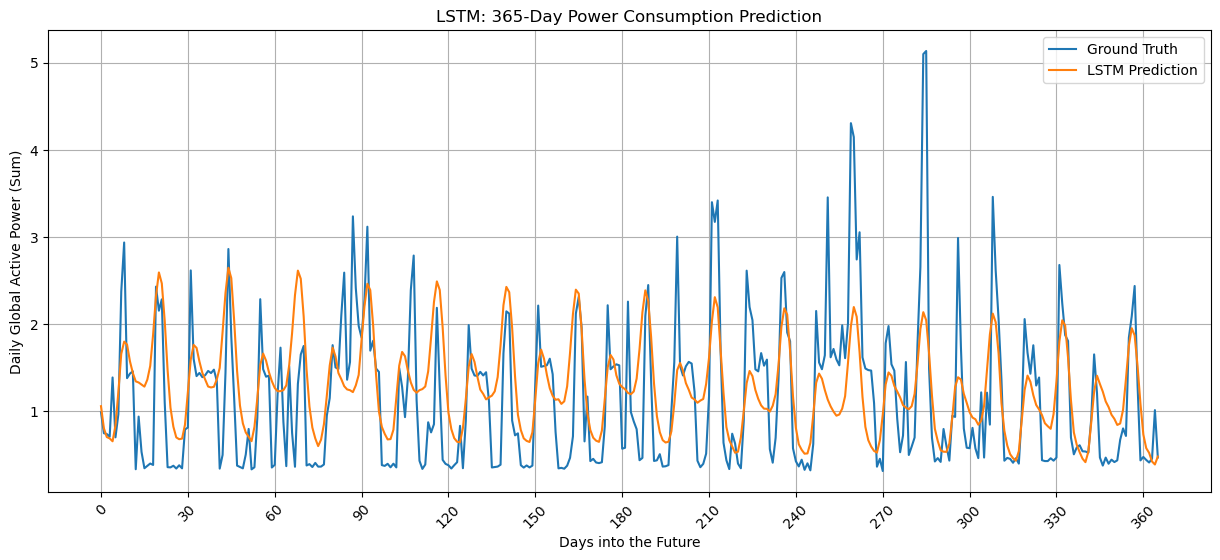

In [14]:
# 3. 绘图
plt.figure(figsize=(15, 6))
plt.plot(actuals[0, :366], label='Ground Truth')
plt.plot(predictions[0, :366], label='LSTM Prediction')
plt.title('LSTM: 365-Day Power Consumption Prediction')
plt.xlabel('Days into the Future')
plt.ylabel('Daily Global Active Power (Sum)')

plt.xticks(np.arange(0, 366, 30), rotation=45)
plt.legend()
plt.grid(True)
plt.show()

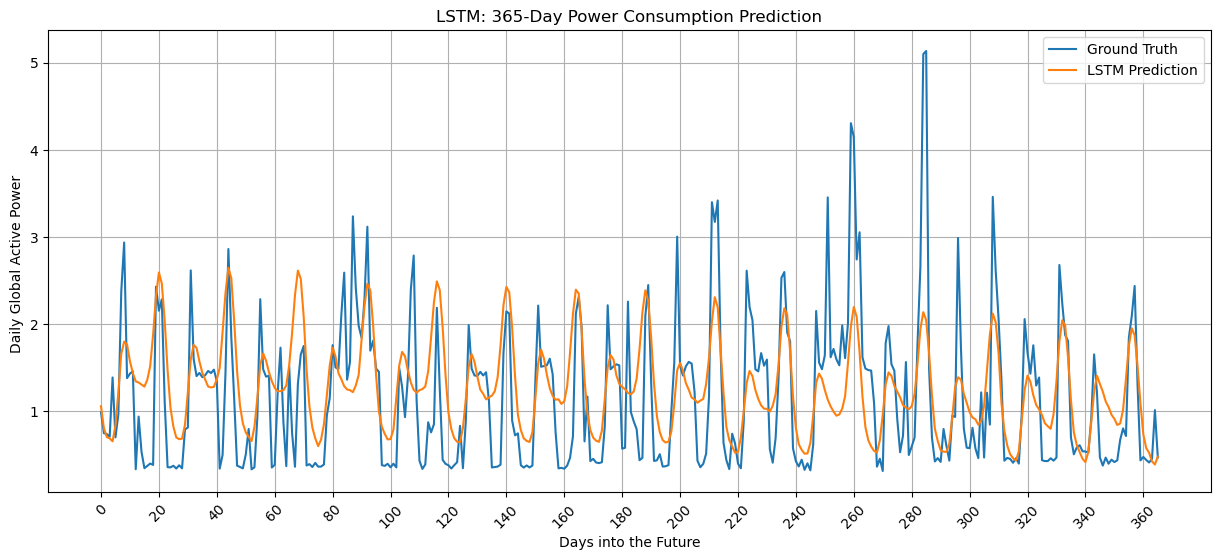

In [17]:
# 3. 绘图
plt.figure(figsize=(15, 6))
plt.plot(actuals[0, :366], label='Ground Truth')
plt.plot(predictions[0, :366], label='LSTM Prediction')
plt.title('LSTM: 365-Day Power Consumption Prediction')
plt.xlabel('Days into the Future')
plt.ylabel('Daily Global Active Power ')

plt.xticks(np.arange(0, 366, 20), rotation=45)
plt.legend()
plt.grid(True)
plt.savefig("365.png")
plt.show()

In [18]:
model

LSTMModel(
  (lstm): LSTM(12, 256, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8760, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [19]:
torch.save(model, "best_model.pth")

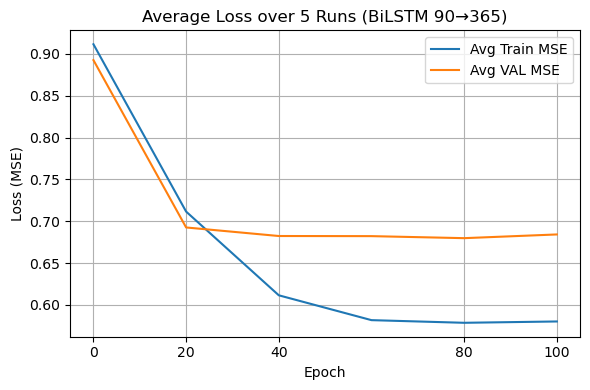

TypeError: 'NoneType' object is not callable

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 手动整理的训练和测试 loss 数据
epochs = [20, 40, 60, 80, 100]

train_losses = np.array([
    [0.650281, 0.603283, 0.588358, 0.584315, 0.582944],
    [0.790132, 0.662114, 0.578264, 0.573906, 0.572859],
    [0.596926, 0.586028, 0.562479, 0.560500, 0.559756],
    [0.761556, 0.611036, 0.598599, 0.595788, 0.594609],
    [0.759030, 0.595194, 0.581493, 0.578848, 0.591125]
])

test_losses = np.array([
    [0.609307, 0.620824, 0.586821, 0.588067, 0.598550],
    [0.778315, 0.767525, 0.780945, 0.778769, 0.777526],
    [0.695648, 0.728458, 0.764693, 0.749132, 0.751427],
    [0.722877, 0.618091, 0.606454, 0.613949, 0.611338],
    [0.656921, 0.677093, 0.672324, 0.669233, 0.682486]
])



plt.figure(figsize=(6, 4))
plt.plot(x_dense, interp_train(x_dense), label='Avg Train MSE', color='tab:blue')
plt.plot(x_dense, interp_test(x_dense), label='Avg VAL MSE', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.xticks([0, 20, 40, 80, 100])
plt.title('Average Loss over 5 Runs (BiLSTM 90→365)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()()
plt.show()